# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import tensorflow as tf

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
tensorflow -> {tf.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
tensorflow -> 2.8.0



In [3]:
###### configurations for image quality#######
# plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

# Preparing Time Series Data for Deep Learning

In [4]:
path = Path('../../datasets/Ch13/')

In [5]:
# weather = pd.read_csv(path.joinpath('jena_climate_2009_2016.csv.zip'), 
#                       index_col='DateTime', 
#                       usecols=['DateTime','Temperature'], 
#                       parse_dates=True)

In [6]:
# daily_weather = weather.resample('D').mean()

In [7]:
# store the data set as a csv file
#daily_weather.to_csv(path.joinpath('daily_weather.csv'))

In [8]:
# Read the daily_weather.csv 
daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)

In [9]:
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['total_energy']

In [10]:
air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)

### Visualize the time series data

<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

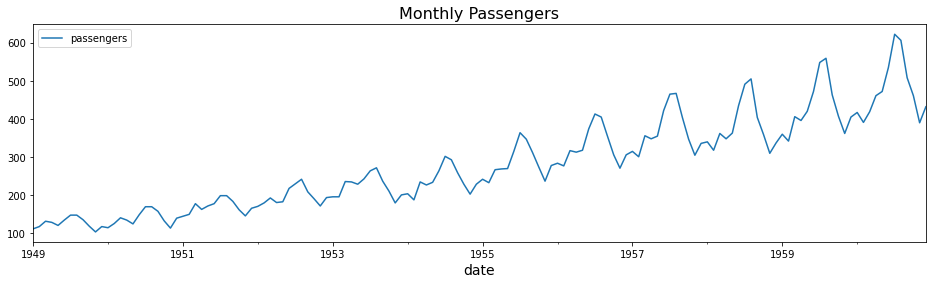

In [11]:
air.plot(title='Monthly Passengers')

<AxesSubplot:title={'center':'Avg Daily Weather Temperature in C'}, xlabel='DateTime'>

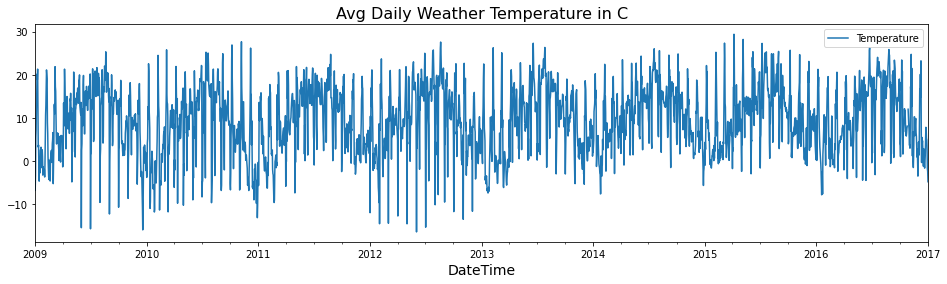

In [12]:
daily_weather.plot(title='Avg Daily Weather Temperature in C')

<AxesSubplot:title={'center':'2012 Avg Daily Weather Temperature Pattern in C'}, xlabel='DateTime'>

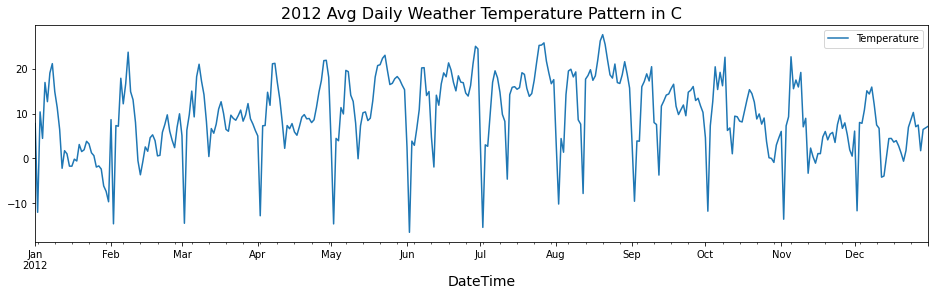

In [13]:
daily_weather.loc['2012'].plot(title='2012 Avg Daily Weather Temperature Pattern in C')

<AxesSubplot:title={'center':'Monthly Energy Consumption'}, xlabel='Month'>

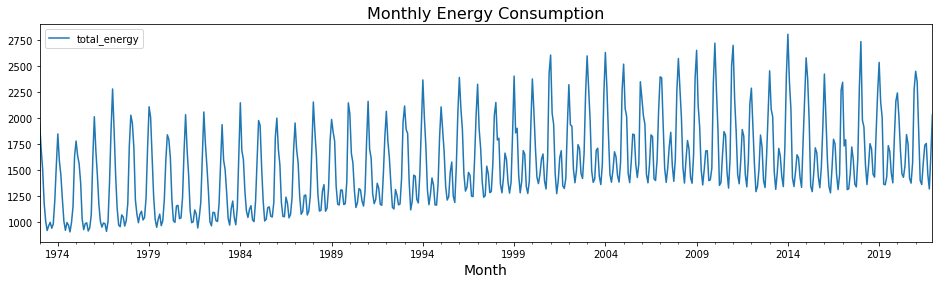

In [14]:
energy.plot(title='Monthly Energy Consumption')

<AxesSubplot:title={'center':'2012-2014 Monthly Energy Consumption Pattern'}, xlabel='Month'>

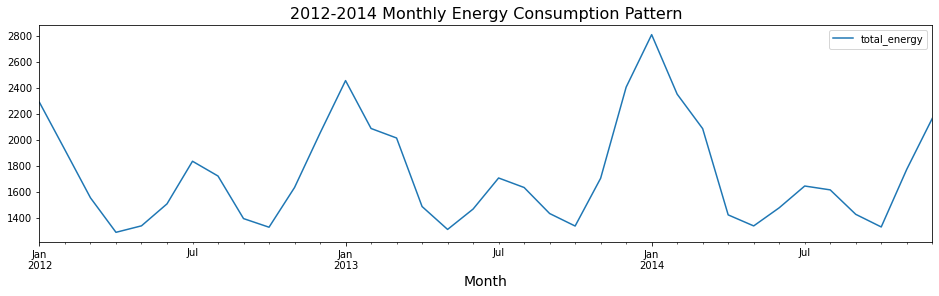

In [15]:
energy.loc['2012':'2014'].plot(title='2012-2014 Monthly Energy Consumption Pattern')

In [16]:
energy.isna().sum()

total_energy    0
dtype: int64

In [17]:
daily_weather.ffill(inplace=True)

In [18]:
daily_weather.isna().sum()

Temperature    0
dtype: int64

In [19]:
air.isna().sum()

passengers    0
dtype: int64

## Tranform the data sets
### Windowing

In [20]:
def one_step_sliding_window(df, steps):
    d = df.values
    x, y = [], []
    n = len(df)
    idx = df.index[:-steps]
    for start in range(n-steps):
        end = start + steps
        x.append(d[start:end].ravel())
        y.append(d[end])
    cols = [f'x_{i}' for i in range(1, steps+1)]
    x_df = pd.DataFrame(np.array(x), columns=cols, index=idx)
    y_df = pd.Series(np.array(y).reshape(-1), name='y', index=idx)
    return pd.concat([x_df, y_df], axis=1)

In [21]:
sliding_window = 5
air_d = one_step_sliding_window(air, sliding_window)
dw_d = one_step_sliding_window(daily_weather, sliding_window)
en_d = one_step_sliding_window(energy, sliding_window)

In [22]:
air_d.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112,118,132,129,121,135
1949-02-28,118,132,129,121,135,148
1949-03-31,132,129,121,135,148,148
1949-04-30,129,121,135,148,148,136
1949-05-31,121,135,148,148,136,119


In [23]:
dw_d.head()

,x_1,x_2,x_3,x_4,x_5,y
DateTime,,,,,,
2009-01-01,-6.810629,-3.360486,5.435694,7.283889,12.690069,15.201597
2009-01-02,-3.360486,5.435694,7.283889,12.690069,15.201597,20.121875
2009-01-03,5.435694,7.283889,12.690069,15.201597,20.121875,18.864792
2009-01-04,7.283889,12.690069,15.201597,20.121875,18.864792,21.289722
2009-01-05,12.690069,15.201597,20.121875,18.864792,21.289722,11.937847


In [24]:
en_d.head()

,x_1,x_2,x_3,x_4,x_5,y
Month,,,,,,
1973-01-01,1957.641,1712.143,1510.079,1183.421,1006.326,914.949
1973-02-01,1712.143,1510.079,1183.421,1006.326,914.949,961.872
1973-03-01,1510.079,1183.421,1006.326,914.949,961.872,994.259
1973-04-01,1183.421,1006.326,914.949,961.872,994.259,937.083
1973-05-01,1006.326,914.949,961.872,994.259,937.083,978.162


### Scale and split data

In [25]:
class Standardize:
    def __init__(self, df, split=0.15):
        self.data = df
        self.split = split
    
    def _split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit(self):
        train, test, val = self._split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [26]:
scale_air = Standardize(air_d)
scale_dw = Standardize(dw_d)
scale_en = Standardize(en_d)

train_air, test_air, val_air = scale_air.fit()
train_dw, test_dw, val_dw = scale_dw.fit()
train_en, test_en, val_en = scale_en.fit()

In [27]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 102 , test: 20, val:17
weather: train: 2109 , test: 437, val:372
energy: train: 422 , test: 87, val: 74



In [28]:
train_air.head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,-1.418086,-1.335433,-1.163321,-1.213649,-1.331677,-1.193676
1949-02-28,-1.340522,-1.160959,-1.199458,-1.308609,-1.165784,-1.038787
1949-03-31,-1.159538,-1.198346,-1.295820,-1.142429,-1.011740,-1.038787
1949-04-30,-1.198320,-1.298045,-1.127185,-0.988119,-1.011740,-1.181762
1949-05-31,-1.301740,-1.123572,-0.970596,-0.988119,-1.153934,-1.384309


In [29]:
scale_air.inverse(train_air).head()

,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0


### Split into X and Y (Features and Target)

In [30]:
def features_target(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [31]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target(train_air, 
                               val_air, 
                               test_air)

In [32]:
(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target(train_dw, 
                             val_dw, 
                             test_dw)

In [33]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target(train_en, 
                             val_en, 
                             test_en)

In [34]:
scale_air.inverse_y(y_train_air)[0:5]

array([[135.],
       [148.],
       [148.],
       [136.],
       [119.]])

In [35]:
x_train_air.shape

(102, 5, 1)

In [36]:
print(y_train_air.shape,
y_test_air.shape,
y_val_air.shape)

(102, 1) (20, 1) (17, 1)


## There is more

In [37]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

In [38]:
# train, test = train_test_split(air_d, test_size=0.15, shuffle=False)
# train, val = train_test_split(train, test_size=0.15, shuffle=False)

In [39]:
# scale = StandardScaler()
# scale.fit(train)

In [40]:
# train_scaled = scale.transform(train)
# test_scaled = scale.transform(test)
# val_scaled = scale.transform(val)

In [41]:
# x_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
# x_test, y_test = test_scaled[:, :-1], test_scaled[:, -1]
# x_val, y_val = val_scaled[:, :-1], val_scaled[:, -1]

# Forecasting with Keras

In [42]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

## SimpleRNN

In [43]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [44]:
def train_model(model, 
                x_train, 
                y_train, 
                x_val, 
                y_val, 
                epochs=100, 
                patience=10, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                       min_delta=0, 
                                       patience=patience)
    
    history = model.fit(x_train,
              y_train, 
              shuffle=False, 
              epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es],
              verbose=1)
    return history

In [45]:
def plot_forecast(model, x_test, y_test, index, history):
    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    pd.Series(history.history['root_mean_squared_error']).plot(ax=ax1, 
                                                               title='RMSE by EPOCH',
                                                              label='rmse')
    pd.Series(history.history['val_root_mean_squared_error']).plot(ax=ax1,
                                                                  label='val_rmse')
    plt.legend()

    ax2 = plt.subplot2grid((2, 2), (0, 1))
    pd.Series(history.history['mean_absolute_error']).plot(ax=ax2,
                                                          title='MAE by EPOCH',
                                                          label='mae')
    pd.Series(history.history['val_mean_absolute_error']).plot(ax=ax2,
                                                              label='val_mae')
    plt.legend()
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax3, 
                                title='Forecast vs Actual',
                               label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(style='k', label='Forecast', ax=ax3)
    plt.legend();plt.show()


### Air Passenger

In [46]:
model_a_simpleRNN = create_model(train=x_train_air, units=32)

2022-04-20 22:02:58.381892: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [48]:
history_a_simpleRNN = train_model(model_a_simpleRNN, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 1s 66ms/step - loss: 0.9707 - root_mean_squared_error: 0.9852 - mean_absolute_error: 0.8161 - val_loss: 2.4422 - val_root_mean_squared_error: 1.5627 - val_mean_absolute_error: 1.3956
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.5941 - root_mean_squared_error: 0.7708 - mean_absolute_error: 0.6292 - val_loss: 1.4752 - val_root_mean_squared_error: 1.2146 - val_mean_absolute_error: 0.9867
Epoch 3/100
4/4 [==============================] - 0s 9ms/step - loss: 0.5350 - root_mean_squared_error: 0.7314 - mean_absolute_error: 0.5871 - val_loss: 0.9190 - val_root_mean_squared_error: 0.9586 - val_mean_absolute_error: 0.6808
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 0.4412 - root_mean_squared_error: 0.6643 - mean_absolute_error: 0.5398 - val_loss: 0.6431 - val_root_mean_squared_error: 0.8019 - val_mean_absolute_error: 0.5597
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - lo

In [49]:
history_a_simpleRNN.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error'])

In [50]:
model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 18ms/step - loss: 0.8214 - root_mean_squared_error: 0.9063 - mean_absolute_error: 0.7325


[0.821363627910614, 0.906291127204895, 0.7325075268745422]

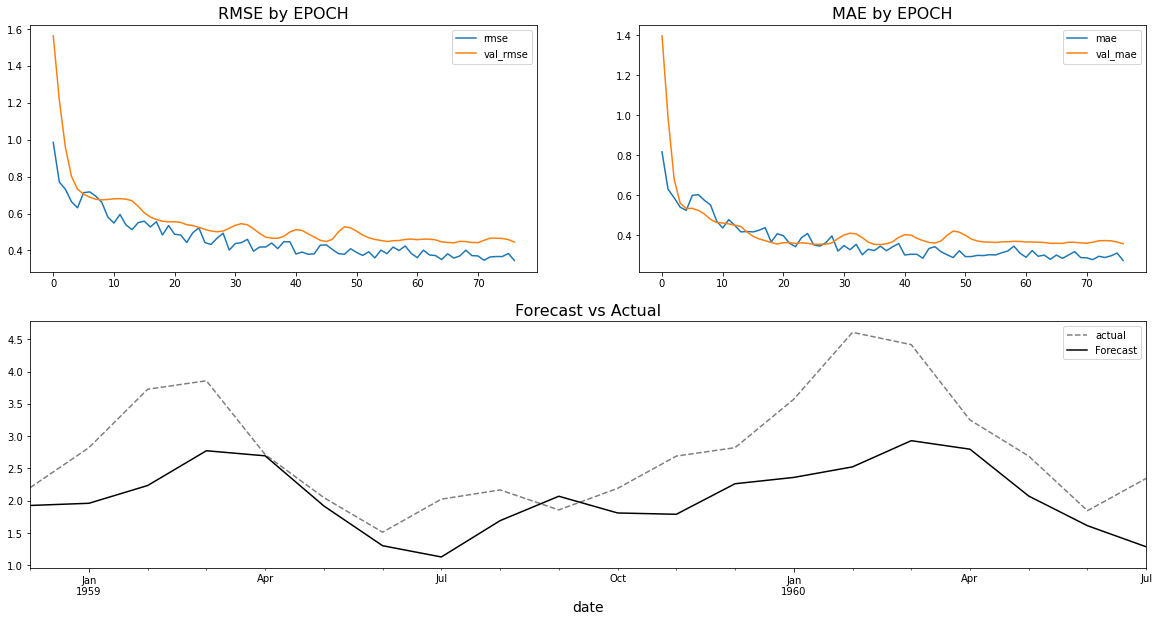

In [51]:
plot_forecast(model_a_simpleRNN, x_test_air, y_test_air, test_air.index, history_a_simpleRNN)

### Avg Daily Temp

In [52]:
model_dw_simpleRNN = create_model(x_train_dw, units=32)

In [53]:
model_dw_simpleRNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [54]:
history_dw_simpleRNN = train_model(model_dw_simpleRNN, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 1s 8ms/step - loss: 0.6084 - root_mean_squared_error: 0.7800 - mean_absolute_error: 0.5912 - val_loss: 0.3325 - val_root_mean_squared_error: 0.5766 - val_mean_absolute_error: 0.4329
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4970 - root_mean_squared_error: 0.7050 - mean_absolute_error: 0.5174 - val_loss: 0.3176 - val_root_mean_squared_error: 0.5636 - val_mean_absolute_error: 0.4233
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4693 - root_mean_squared_error: 0.6850 - mean_absolute_error: 0.4917 - val_loss: 0.3169 - val_root_mean_squared_error: 0.5629 - val_mean_absolute_error: 0.4155
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.4611 - root_mean_squared_error: 0.6791 - mean_absolute_error: 0.4903 - val_loss: 0.3144 - val_root_mean_squared_error: 0.5607 - val_mean_absolute_error: 0.4143
Epoch 5/100
33/33 [==============================] - 0s 3ms/

In [55]:
model_dw_simpleRNN.evaluate(x=x_test_dw, y=y_test_dw)

14/14 [==============================] - 0s 1ms/step - loss: 0.3524 - root_mean_squared_error: 0.5936 - mean_absolute_error: 0.4494


[0.3523637056350708, 0.5936022996902466, 0.4494483172893524]

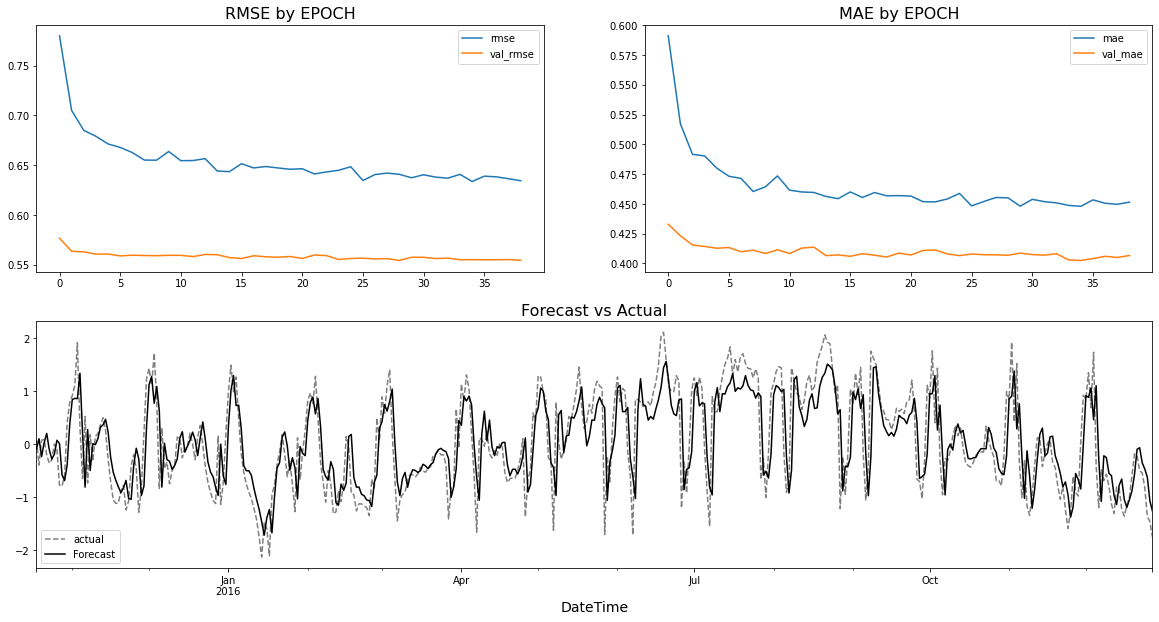

In [56]:
plot_forecast(model_dw_simpleRNN, x_test_dw, y_test_dw, test_dw.index, history_dw_simpleRNN)

### Energy Consumption

In [57]:
model_en_simpleRNN = create_model(x_train_en, units=32)
model_en_simpleRNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1088      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [58]:
history_en_simpleRNN = train_model(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 1s 30ms/step - loss: 0.6024 - root_mean_squared_error: 0.7762 - mean_absolute_error: 0.6185 - val_loss: 0.6768 - val_root_mean_squared_error: 0.8227 - val_mean_absolute_error: 0.5756
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.4604 - root_mean_squared_error: 0.6786 - mean_absolute_error: 0.5410 - val_loss: 0.5471 - val_root_mean_squared_error: 0.7396 - val_mean_absolute_error: 0.5193
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3750 - root_mean_squared_error: 0.6123 - mean_absolute_error: 0.4881 - val_loss: 0.4653 - val_root_mean_squared_error: 0.6821 - val_mean_absolute_error: 0.4963
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.4245 - root_mean_squared_error: 0.6516 - mean_absolute_error: 0.5198 - val_loss: 0.4380 - val_root_mean_squared_error: 0.6618 - val_mean_absolute_error: 0.4906
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - lo

In [59]:
model_en_simpleRNN.evaluate(x=x_test_en, y=y_test_en)

3/3 [==============================] - 0s 2ms/step - loss: 0.2834 - root_mean_squared_error: 0.5323 - mean_absolute_error: 0.4116


[0.2833670377731323, 0.5323222875595093, 0.4116043448448181]

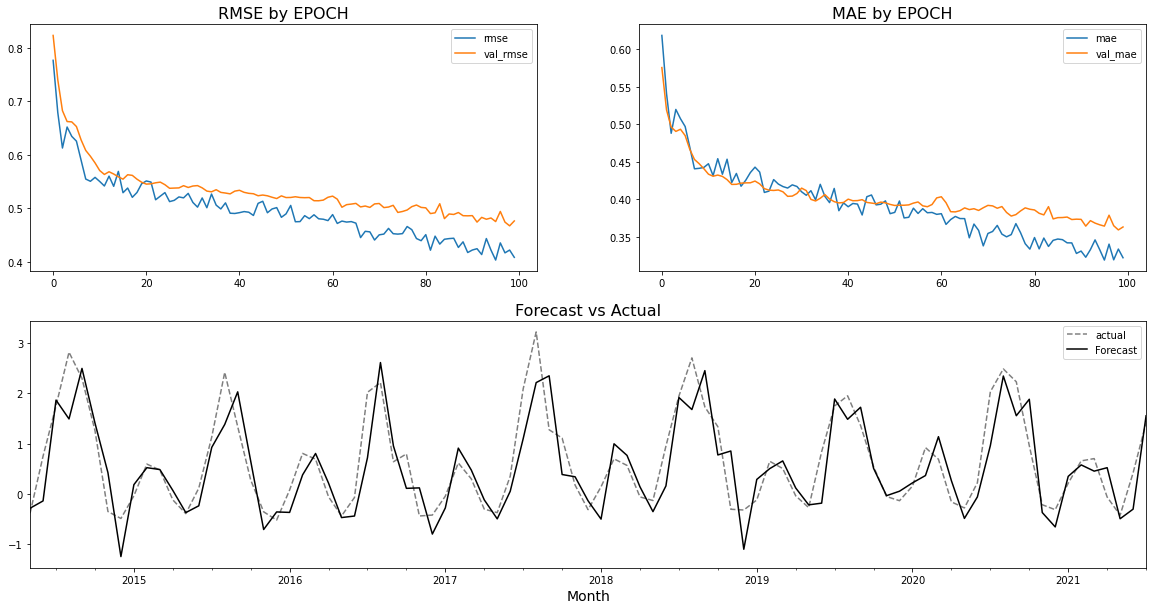

In [60]:
plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

In [61]:
scale_en.inverse_y(y_test_en[0:5])

array([[1331.478],
       [1773.932],
       [2164.807],
       [2580.929],
       [2377.381]])

In [62]:
scale_en.inverse_y(model_en_simpleRNN.predict(x_test_en)[0:5])

array([[1370.1046],
       [1426.6461],
       [2209.2322],
       [2062.9697],
       [2455.0054]], dtype=float32)

## LSTM

In [63]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [64]:
model_a_lstm = create_model(train=x_train_air, units=32)
model_a_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [65]:
history_a_lstm = train_model(model_a_lstm, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 2s 128ms/step - loss: 1.0294 - root_mean_squared_error: 1.0146 - mean_absolute_error: 0.8284 - val_loss: 3.0865 - val_root_mean_squared_error: 1.7568 - val_mean_absolute_error: 1.6316
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.9305 - root_mean_squared_error: 0.9646 - mean_absolute_error: 0.7844 - val_loss: 2.8322 - val_root_mean_squared_error: 1.6829 - val_mean_absolute_error: 1.5504
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.8675 - root_mean_squared_error: 0.9314 - mean_absolute_error: 0.7466 - val_loss: 2.5876 - val_root_mean_squared_error: 1.6086 - val_mean_absolute_error: 1.4679
Epoch 4/100
4/4 [==============================] - 0s 12ms/step - loss: 0.7793 - root_mean_squared_error: 0.8828 - mean_absolute_error: 0.7150 - val_loss: 2.3561 - val_root_mean_squared_error: 1.5349 - val_mean_absolute_error: 1.3851
Epoch 5/100
4/4 [==============================] - 0s 11ms/step

In [66]:
model_a_lstm.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 24ms/step - loss: 1.2338 - root_mean_squared_error: 1.1108 - mean_absolute_error: 0.8658


[1.2338261604309082, 1.1107772588729858, 0.8657602071762085]

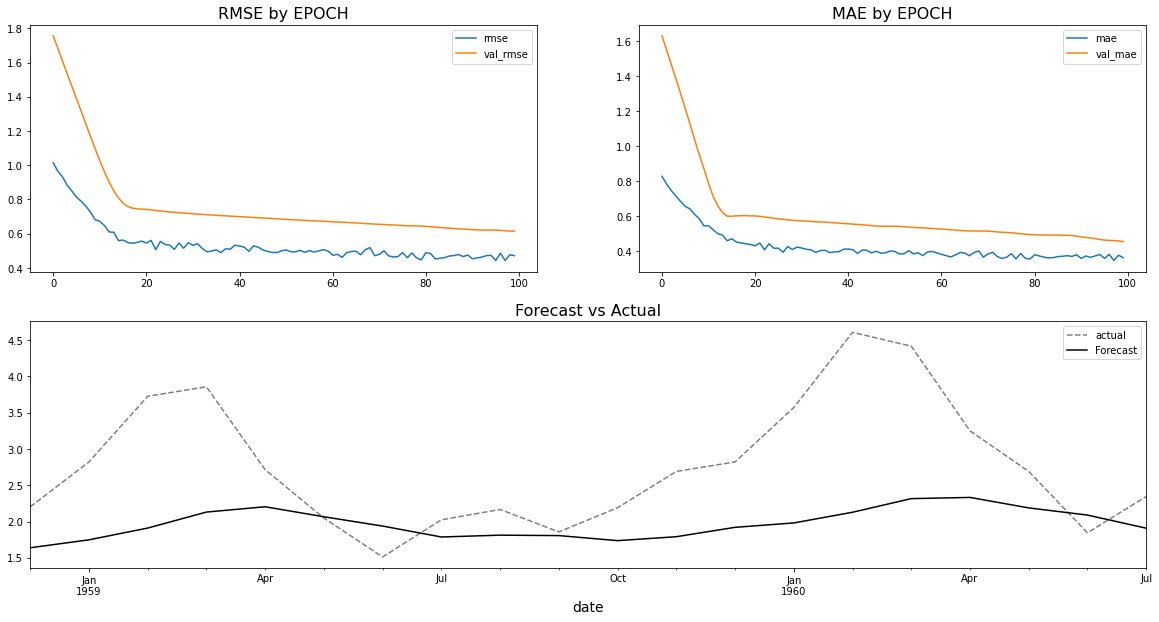

In [67]:
plot_forecast(model_a_lstm, x_test_air, y_test_air, test_air.index, history_a_lstm)

### Avg Daily Temp

In [68]:
model_dw_lstm = create_model(train=x_train_dw, units=32)
model_dw_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [69]:
history_dw_lstm = train_model(model_dw_lstm, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 2s 14ms/step - loss: 1.0266 - root_mean_squared_error: 1.0132 - mean_absolute_error: 0.8398 - val_loss: 0.7154 - val_root_mean_squared_error: 0.8458 - val_mean_absolute_error: 0.6849
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.8250 - root_mean_squared_error: 0.9083 - mean_absolute_error: 0.7373 - val_loss: 0.6106 - val_root_mean_squared_error: 0.7814 - val_mean_absolute_error: 0.6020
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.7457 - root_mean_squared_error: 0.8636 - mean_absolute_error: 0.6814 - val_loss: 0.5597 - val_root_mean_squared_error: 0.7481 - val_mean_absolute_error: 0.5683
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.6960 - root_mean_squared_error: 0.8343 - mean_absolute_error: 0.6511 - val_loss: 0.5178 - val_root_mean_squared_error: 0.7196 - val_mean_absolute_error: 0.5461
Epoch 5/100
33/33 [==============================] - 0s 4ms

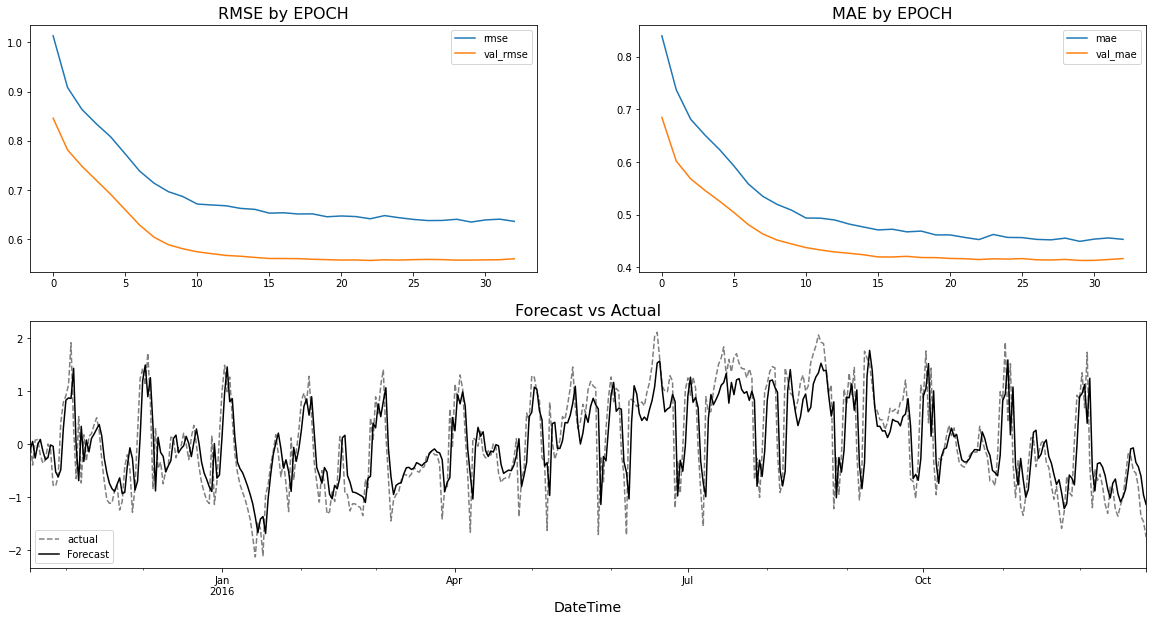

In [70]:
plot_forecast(model_dw_lstm, x_test_dw, y_test_dw, test_dw.index, history_dw_lstm)

### Energy Consumption

In [71]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [72]:
history_en_lstm = train_model(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 71ms/step - loss: 1.0717 - root_mean_squared_error: 1.0352 - mean_absolute_error: 0.8480 - val_loss: 1.6426 - val_root_mean_squared_error: 1.2816 - val_mean_absolute_error: 0.8926
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 1.0274 - root_mean_squared_error: 1.0136 - mean_absolute_error: 0.8296 - val_loss: 1.5758 - val_root_mean_squared_error: 1.2553 - val_mean_absolute_error: 0.8750
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.9977 - root_mean_squared_error: 0.9989 - mean_absolute_error: 0.8226 - val_loss: 1.5136 - val_root_mean_squared_error: 1.2303 - val_mean_absolute_error: 0.8616
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.9551 - root_mean_squared_error: 0.9773 - mean_absolute_error: 0.8034 - val_loss: 1.4590 - val_root_mean_squared_error: 1.2079 - val_mean_absolute_error: 0.8524
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - lo

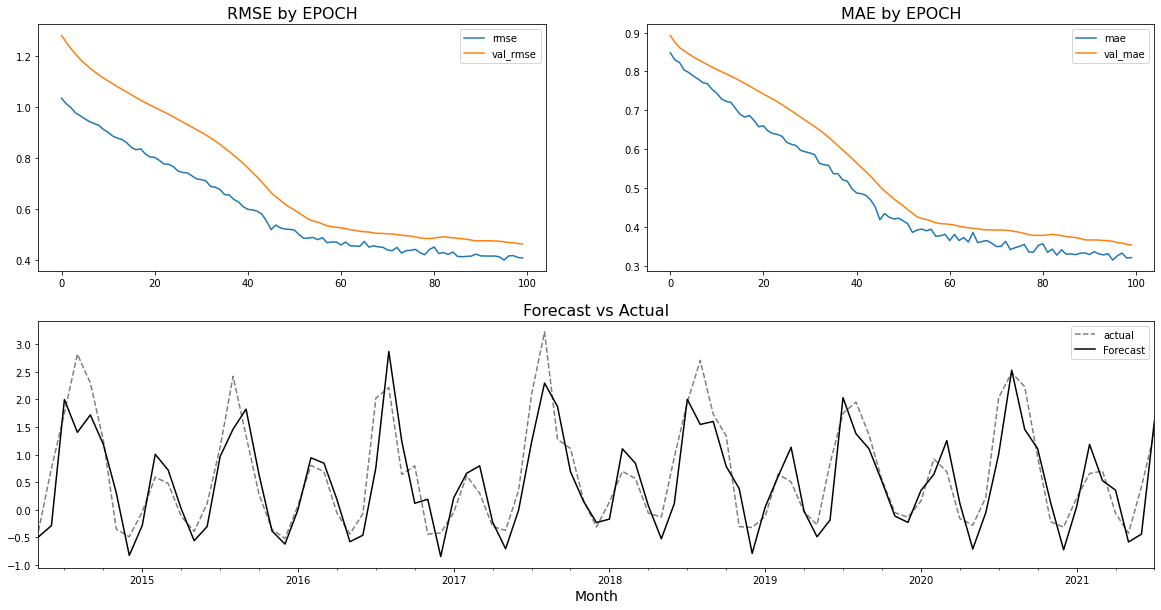

In [73]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## GRU

In [74]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units,
                  input_shape=(train.shape[1], 
                               train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [75]:
model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)


Epoch 1/100
4/4 [==============================] - 2s 135ms/step - loss: 0.7241 - root_mean_squared_error: 0.8509 - mean_absolute_error: 0.6787 - val_loss: 2.0452 - val_root_mean_squared_error: 1.4301 - val_mean_absolute_error: 1.2927
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.5286 - root_mean_squared_error: 0.7271 - mean_absolute_error: 0.5813 - val_loss: 1.7451 - val_root_mean_squared_error: 1.3210 - val_mean_absolute_error: 1.1715
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.4702 - root_mean_squared_error: 0.6857 - mean_absolute_error: 0.5513 - val_loss: 1.4761 - val_root_mean_squared_error: 1.2149 - val_mean_absolute_error: 1.0506
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.4171 - root_mean_squared_error: 0.6458 - mean_absolute_error: 0.5092 - val_loss: 1.2427 - val_root_mean_squared_error: 1.1148 - val_mean_absolute_error: 0.9371
Epoch 5/100
4/4 [==============================] - 0s 13ms/step

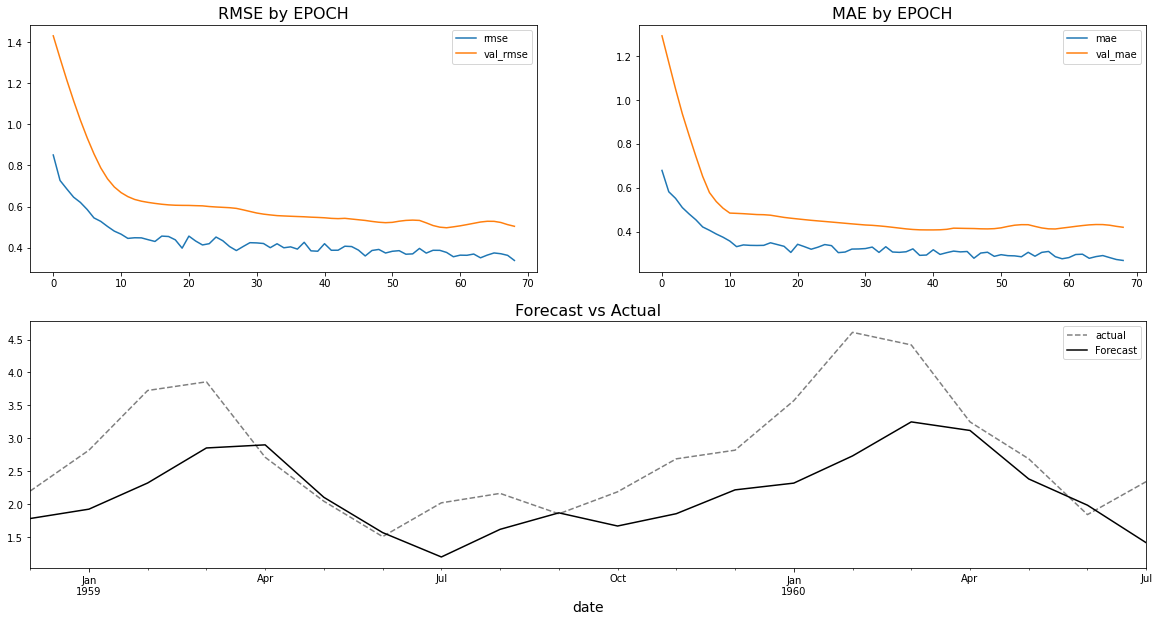

In [76]:
plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)

### Avg Daily Temp

In [77]:
model_dw_gru = create_model(train=x_train_dw, units=32)
history_dw_gru = train_model(model_dw_gru, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 2s 15ms/step - loss: 0.7145 - root_mean_squared_error: 0.8453 - mean_absolute_error: 0.6797 - val_loss: 0.4803 - val_root_mean_squared_error: 0.6930 - val_mean_absolute_error: 0.5284
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5929 - root_mean_squared_error: 0.7700 - mean_absolute_error: 0.5865 - val_loss: 0.4205 - val_root_mean_squared_error: 0.6484 - val_mean_absolute_error: 0.4830
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5367 - root_mean_squared_error: 0.7326 - mean_absolute_error: 0.5464 - val_loss: 0.3791 - val_root_mean_squared_error: 0.6157 - val_mean_absolute_error: 0.4596
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.4946 - root_mean_squared_error: 0.7033 - mean_absolute_error: 0.5218 - val_loss: 0.3470 - val_root_mean_squared_error: 0.5891 - val_mean_absolute_error: 0.4410
Epoch 5/100
33/33 [==============================] - 0s 3ms

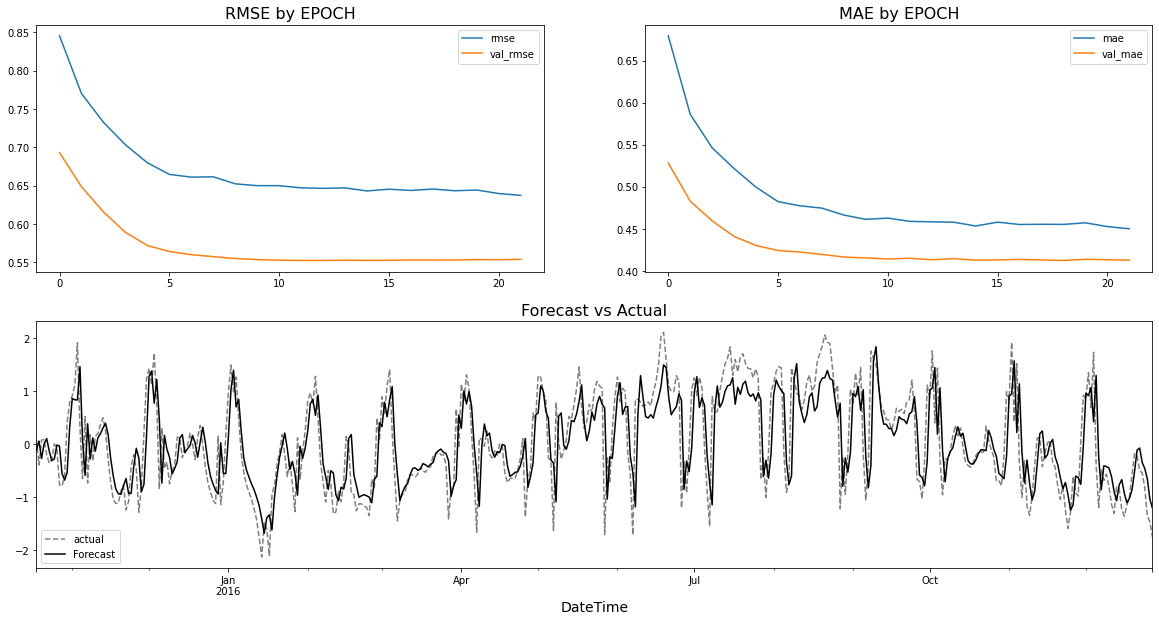

In [78]:
plot_forecast(model_dw_gru, x_test_dw, y_test_dw, test_dw.index, history_dw_gru)

### Energy Consumption

In [79]:
model_en_gru = create_model(x_train_en, units=32)
model_en_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 32)                3360      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [80]:
history_en_gru = train_model(model_en_gru, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/100
7/7 [==============================] - 2s 68ms/step - loss: 0.9890 - root_mean_squared_error: 0.9945 - mean_absolute_error: 0.8145 - val_loss: 1.4777 - val_root_mean_squared_error: 1.2156 - val_mean_absolute_error: 0.8574
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.9206 - root_mean_squared_error: 0.9595 - mean_absolute_error: 0.7861 - val_loss: 1.3928 - val_root_mean_squared_error: 1.1802 - val_mean_absolute_error: 0.8432
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 0.8529 - root_mean_squared_error: 0.9235 - mean_absolute_error: 0.7607 - val_loss: 1.3134 - val_root_mean_squared_error: 1.1461 - val_mean_absolute_error: 0.8294
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.8151 - root_mean_squared_error: 0.9028 - mean_absolute_error: 0.7423 - val_loss: 1.2438 - val_root_mean_squared_error: 1.1153 - val_mean_absolute_error: 0.8148
Epoch 5/100
7/7 [==============================] - 0s 11ms/step 

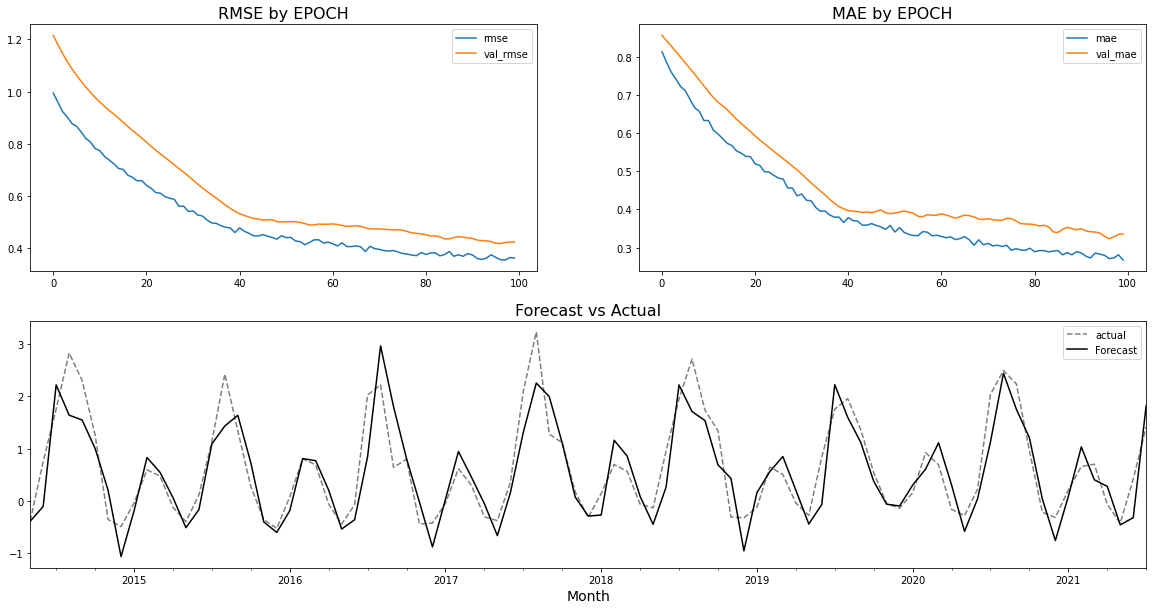

In [81]:
plot_forecast(model_en_gru, x_test_en, y_test_en, test_en.index, history_en_gru)

## Deep RNN-LSTM

### Air Passenger

In [82]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

In [83]:
model_a_deep = create_model(train=x_train_air, units=32)
history_a_deep = train_model(model_a_deep, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 3s 231ms/step - loss: 0.9651 - root_mean_squared_error: 0.9824 - mean_absolute_error: 0.7973 - val_loss: 3.0768 - val_root_mean_squared_error: 1.7541 - val_mean_absolute_error: 1.6289
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8957 - root_mean_squared_error: 0.9464 - mean_absolute_error: 0.7666 - val_loss: 2.8679 - val_root_mean_squared_error: 1.6935 - val_mean_absolute_error: 1.5619
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.8446 - root_mean_squared_error: 0.9190 - mean_absolute_error: 0.7447 - val_loss: 2.6590 - val_root_mean_squared_error: 1.6307 - val_mean_absolute_error: 1.4916
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 0.8142 - root_mean_squared_error: 0.9023 - mean_absolute_error: 0.7288 - val_loss: 2.4471 - val_root_mean_squared_error: 1.5643 - val_mean_absolute_error: 1.4165
Epoch 5/100
4/4 [==============================] - 0s 18ms/step

In [84]:
model_a_deep.evaluate(x_test_air, y_test_air)

1/1 [==============================] - 0s 18ms/step - loss: 1.6824 - root_mean_squared_error: 1.2971 - mean_absolute_error: 1.1595


[1.682355523109436, 1.2970564365386963, 1.1595432758331299]

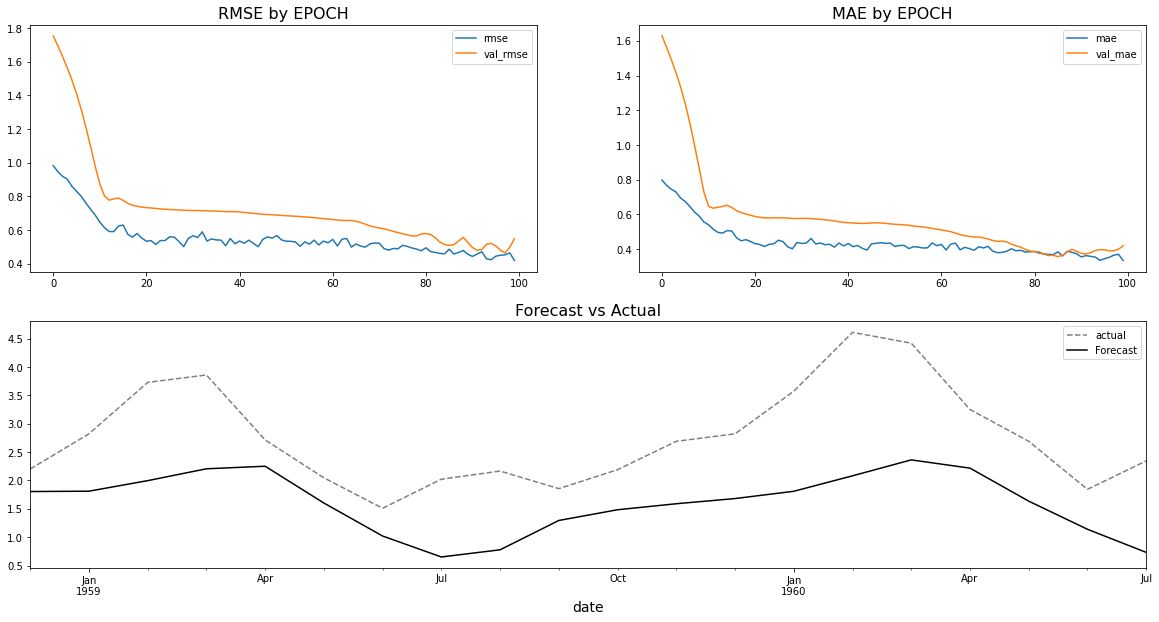

In [85]:
plot_forecast(model_a_deep, x_test_air, y_test_air, test_air.index, history_a_deep)

### Avg Daily Temp

Epoch 1/100
33/33 [==============================] - 4s 30ms/step - loss: 0.8925 - root_mean_squared_error: 0.9447 - mean_absolute_error: 0.7771 - val_loss: 0.6454 - val_root_mean_squared_error: 0.8034 - val_mean_absolute_error: 0.6270
Epoch 2/100
33/33 [==============================] - 0s 8ms/step - loss: 0.7907 - root_mean_squared_error: 0.8892 - mean_absolute_error: 0.7053 - val_loss: 0.5954 - val_root_mean_squared_error: 0.7716 - val_mean_absolute_error: 0.5872
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 0.7360 - root_mean_squared_error: 0.8579 - mean_absolute_error: 0.6727 - val_loss: 0.5491 - val_root_mean_squared_error: 0.7410 - val_mean_absolute_error: 0.5655
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 0.6681 - root_mean_squared_error: 0.8173 - mean_absolute_error: 0.6355 - val_loss: 0.4855 - val_root_mean_squared_error: 0.6968 - val_mean_absolute_error: 0.5331
Epoch 5/100
33/33 [==============================] - 0s 8ms

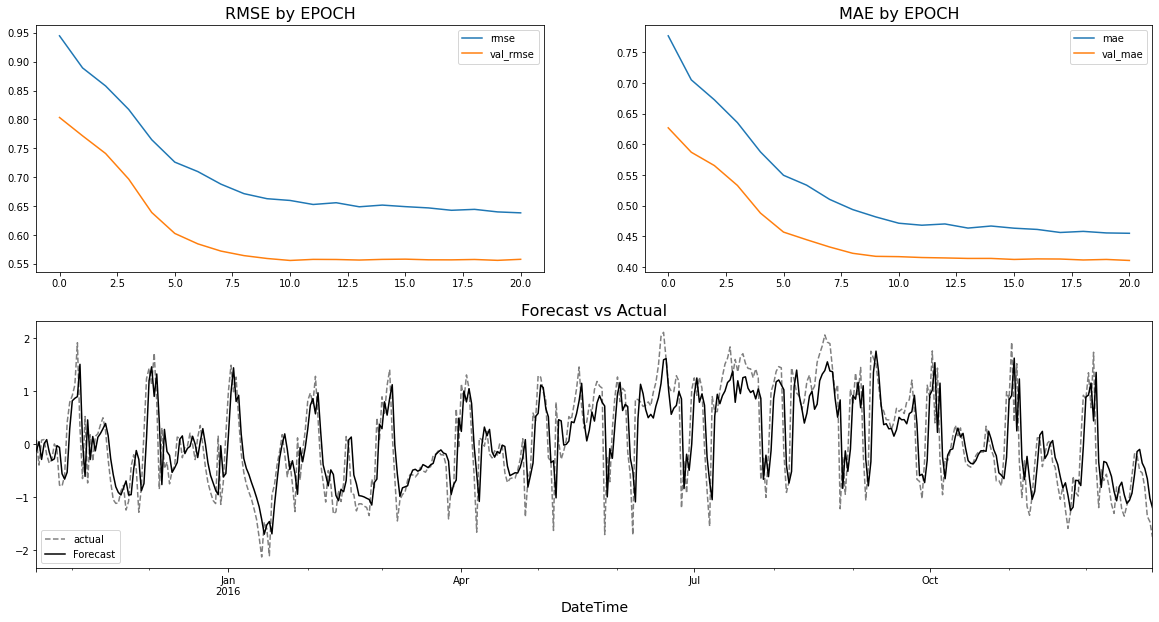

In [86]:
model_dw_deep = create_model(x_train_dw, units=32)
history_dw_deep = train_model(model_dw_deep, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)
plot_forecast(model_dw_deep, x_test_dw, y_test_dw, test_dw.index, history_dw_deep)

### Energy Consumption

Epoch 1/100
7/7 [==============================] - 3s 115ms/step - loss: 1.0026 - root_mean_squared_error: 1.0013 - mean_absolute_error: 0.8223 - val_loss: 1.5604 - val_root_mean_squared_error: 1.2492 - val_mean_absolute_error: 0.8734
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 0.9761 - root_mean_squared_error: 0.9880 - mean_absolute_error: 0.8117 - val_loss: 1.5292 - val_root_mean_squared_error: 1.2366 - val_mean_absolute_error: 0.8700
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 0.9665 - root_mean_squared_error: 0.9831 - mean_absolute_error: 0.8093 - val_loss: 1.4962 - val_root_mean_squared_error: 1.2232 - val_mean_absolute_error: 0.8665
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.9518 - root_mean_squared_error: 0.9756 - mean_absolute_error: 0.8051 - val_loss: 1.4649 - val_root_mean_squared_error: 1.2103 - val_mean_absolute_error: 0.8629
Epoch 5/100
7/7 [==============================] - 0s 11ms/step

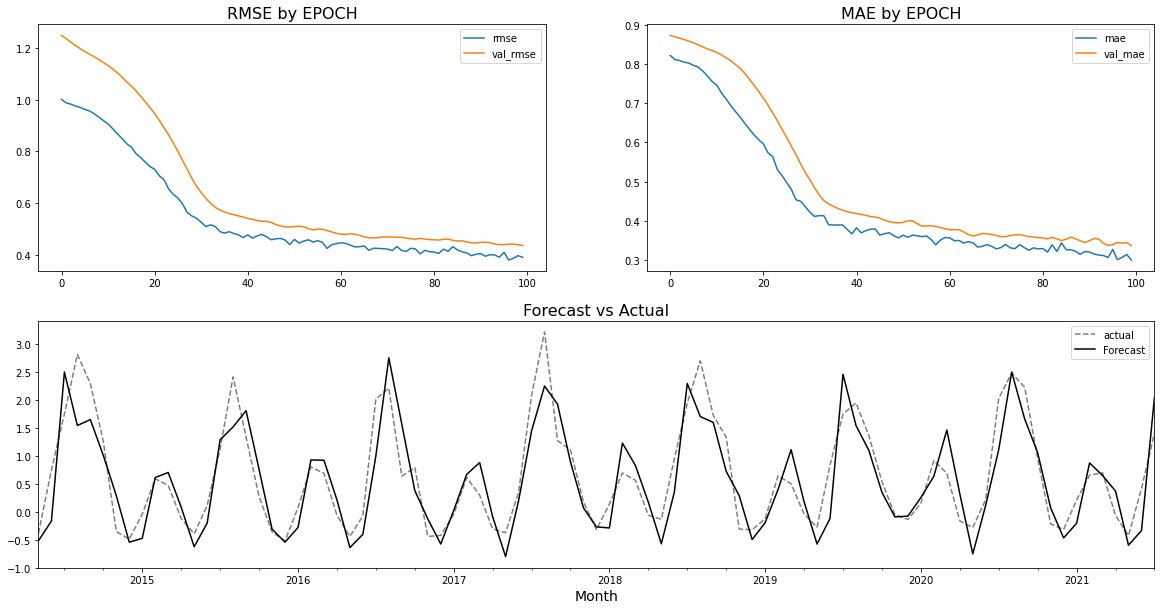

In [87]:
model_en_deep = create_model(x_train_en, units=32)
history_en_deep = train_model(model_en_deep, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_deep, x_test_en, y_test_en, test_en.index, history_en_deep)

## Bidirectional

In [118]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units=units, 
                                 input_shape=(train.shape[1], train.shape[2]), return_sequences=True)))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

### Air Passenger

In [119]:
model_a_bd = create_model(train=x_train_air, units=32)
history_a_bd = train_model(model_a_bd, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 6s 375ms/step - loss: 0.9267 - root_mean_squared_error: 0.9627 - mean_absolute_error: 0.7856 - val_loss: 2.5339 - val_root_mean_squared_error: 1.5918 - val_mean_absolute_error: 1.4508
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6906 - root_mean_squared_error: 0.8310 - mean_absolute_error: 0.6717 - val_loss: 1.8084 - val_root_mean_squared_error: 1.3448 - val_mean_absolute_error: 1.1679
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.5113 - root_mean_squared_error: 0.7150 - mean_absolute_error: 0.5753 - val_loss: 1.2178 - val_root_mean_squared_error: 1.1035 - val_mean_absolute_error: 0.8916
Epoch 4/100
4/4 [==============================] - 0s 23ms/step - loss: 0.3716 - root_mean_squared_error: 0.6096 - mean_absolute_error: 0.4942 - val_loss: 0.7918 - val_root_mean_squared_error: 0.8898 - val_mean_absolute_error: 0.6567
Epoch 5/100
4/4 [==============================] - 0s 14ms/step

In [120]:
model_a_bd.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 25ms/step - loss: 2.3471 - root_mean_squared_error: 1.5320 - mean_absolute_error: 1.3891


[2.3471105098724365, 1.5320281982421875, 1.3891065120697021]

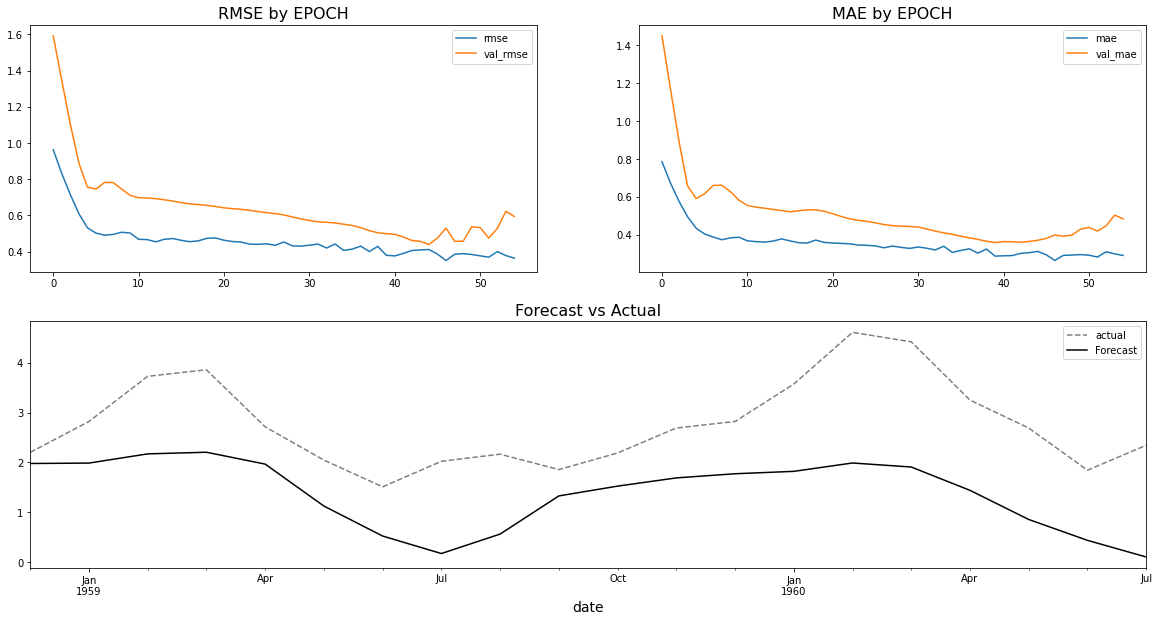

In [121]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [122]:
model_dw_bd = create_model(x_train_dw, units=32)
history_dw_bd = train_model(model_dw_bd, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/100
33/33 [==============================] - 6s 45ms/step - loss: 0.7853 - root_mean_squared_error: 0.8862 - mean_absolute_error: 0.7058 - val_loss: 0.5141 - val_root_mean_squared_error: 0.7170 - val_mean_absolute_error: 0.5232
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 0.6119 - root_mean_squared_error: 0.7822 - mean_absolute_error: 0.5853 - val_loss: 0.4017 - val_root_mean_squared_error: 0.6338 - val_mean_absolute_error: 0.4672
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 0.5080 - root_mean_squared_error: 0.7128 - mean_absolute_error: 0.5230 - val_loss: 0.3326 - val_root_mean_squared_error: 0.5767 - val_mean_absolute_error: 0.4330
Epoch 4/100
33/33 [==============================] - 0s 9ms/step - loss: 0.4719 - root_mean_squared_error: 0.6870 - mean_absolute_error: 0.5027 - val_loss: 0.3248 - val_root_mean_squared_error: 0.5699 - val_mean_absolute_error: 0.4306
Epoch 5/100
33/33 [==============================] - 0s 9ms

In [123]:
x_test_dw.shape

(437, 5, 1)

In [124]:
model_dw_bd.predict(x_test_dw).shape

(437, 1)

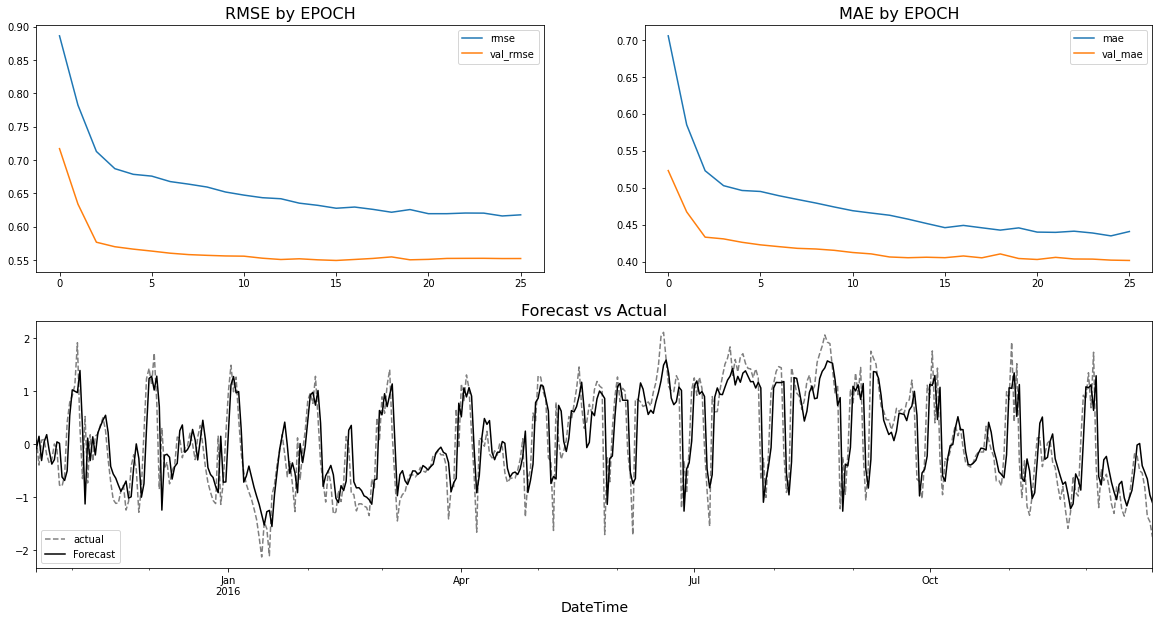

In [125]:
plot_forecast(model_dw_bd, x_test_dw, y_test_dw, test_dw.index, history_dw_bd)

### Energy Consumption

Epoch 1/100
7/7 [==============================] - 7s 204ms/step - loss: 1.0226 - root_mean_squared_error: 1.0112 - mean_absolute_error: 0.8295 - val_loss: 1.5350 - val_root_mean_squared_error: 1.2389 - val_mean_absolute_error: 0.8722
Epoch 2/100
7/7 [==============================] - 0s 13ms/step - loss: 0.9411 - root_mean_squared_error: 0.9701 - mean_absolute_error: 0.7998 - val_loss: 1.4146 - val_root_mean_squared_error: 1.1894 - val_mean_absolute_error: 0.8586
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 0.8877 - root_mean_squared_error: 0.9422 - mean_absolute_error: 0.7786 - val_loss: 1.3119 - val_root_mean_squared_error: 1.1454 - val_mean_absolute_error: 0.8451
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.8456 - root_mean_squared_error: 0.9196 - mean_absolute_error: 0.7567 - val_loss: 1.2229 - val_root_mean_squared_error: 1.1058 - val_mean_absolute_error: 0.8266
Epoch 5/100
7/7 [==============================] - 0s 11ms/step

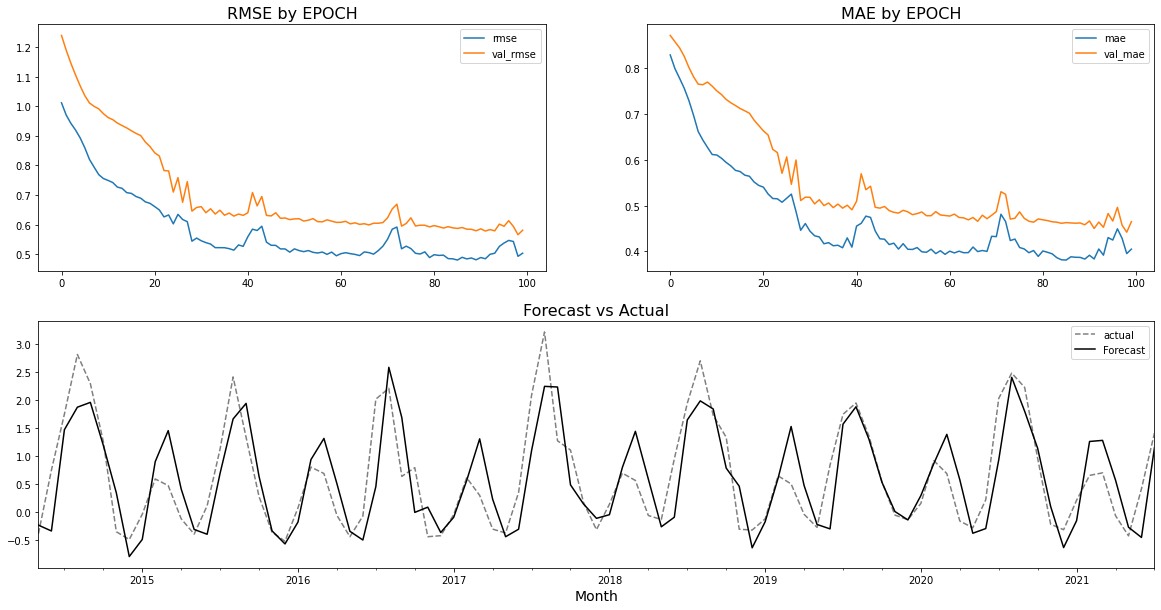

In [126]:
model_en_bd = create_model(x_train_en, units=32)
history_en_bd = train_model(model_en_bd, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_bd, x_test_en, y_test_en, test_en.index, history_en_bd)

## Timedistributed

In [136]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    return model

### Air Passenger

In [137]:
model_a_td = create_model(train=x_train_air, units=32)
history_a_td = train_model(model_a_td, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/100
4/4 [==============================] - 4s 461ms/step - loss: 0.8926 - root_mean_squared_error: 0.9448 - mean_absolute_error: 0.7660 - val_loss: 2.8061 - val_root_mean_squared_error: 1.6751 - val_mean_absolute_error: 1.5348
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.8423 - root_mean_squared_error: 0.9178 - mean_absolute_error: 0.7419 - val_loss: 2.6354 - val_root_mean_squared_error: 1.6234 - val_mean_absolute_error: 1.4725
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.8012 - root_mean_squared_error: 0.8951 - mean_absolute_error: 0.7220 - val_loss: 2.4539 - val_root_mean_squared_error: 1.5665 - val_mean_absolute_error: 1.4016
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: 0.7599 - root_mean_squared_error: 0.8717 - mean_absolute_error: 0.7018 - val_loss: 2.2654 - val_root_mean_squared_error: 1.5051 - val_mean_absolute_error: 1.3212
Epoch 5/100
4/4 [==============================] - 0s 16ms/step

In [138]:
model_a_td.evaluate(x=x_test_air, y=y_test_air)

1/1 [==============================] - 0s 22ms/step - loss: 1.5809 - root_mean_squared_error: 1.2573 - mean_absolute_error: 1.0109


[1.5808935165405273, 1.2573357820510864, 1.010865569114685]

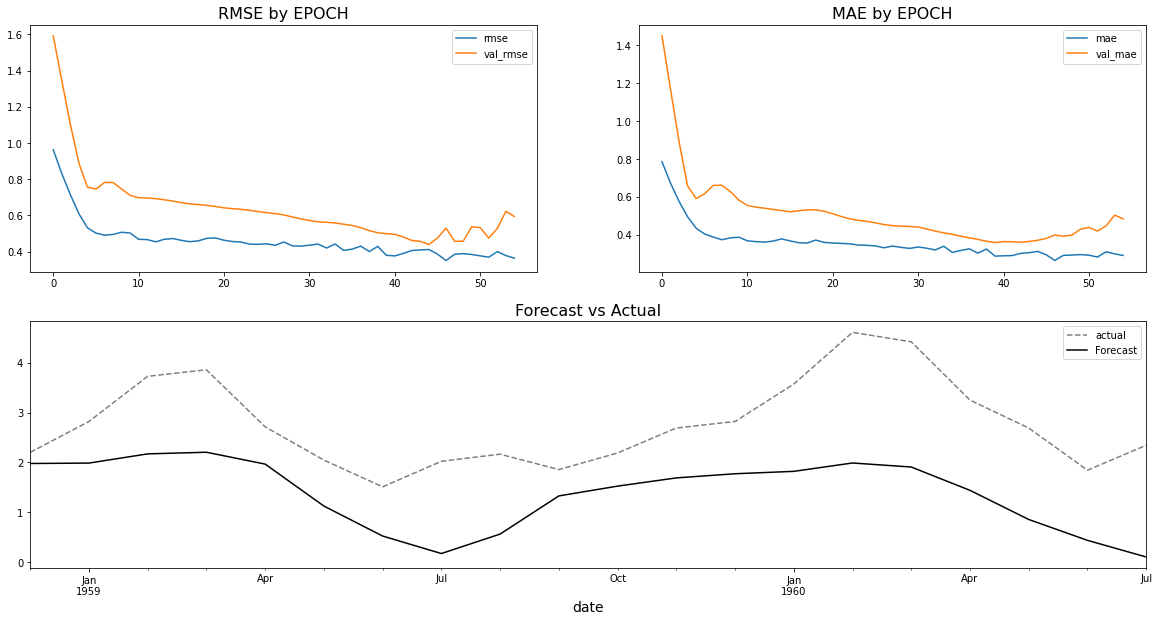

In [139]:
plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)

### Avd Daily Temp

In [142]:
model_dw_td.predict(x_test_en).shape

(87, 5, 1)

Epoch 1/100
33/33 [==============================] - 3s 27ms/step - loss: 0.9659 - root_mean_squared_error: 0.9828 - mean_absolute_error: 0.8140 - val_loss: 0.7373 - val_root_mean_squared_error: 0.8586 - val_mean_absolute_error: 0.6933
Epoch 2/100
33/33 [==============================] - 0s 8ms/step - loss: 0.9032 - root_mean_squared_error: 0.9504 - mean_absolute_error: 0.7741 - val_loss: 0.7101 - val_root_mean_squared_error: 0.8427 - val_mean_absolute_error: 0.6669
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 0.8838 - root_mean_squared_error: 0.9401 - mean_absolute_error: 0.7598 - val_loss: 0.6943 - val_root_mean_squared_error: 0.8333 - val_mean_absolute_error: 0.6593
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 0.8658 - root_mean_squared_error: 0.9305 - mean_absolute_error: 0.7496 - val_loss: 0.6790 - val_root_mean_squared_error: 0.8240 - val_mean_absolute_error: 0.6493
Epoch 5/100
33/33 [==============================] - 0s 7ms

ValueError: Length of values (2185) does not match length of index (437)

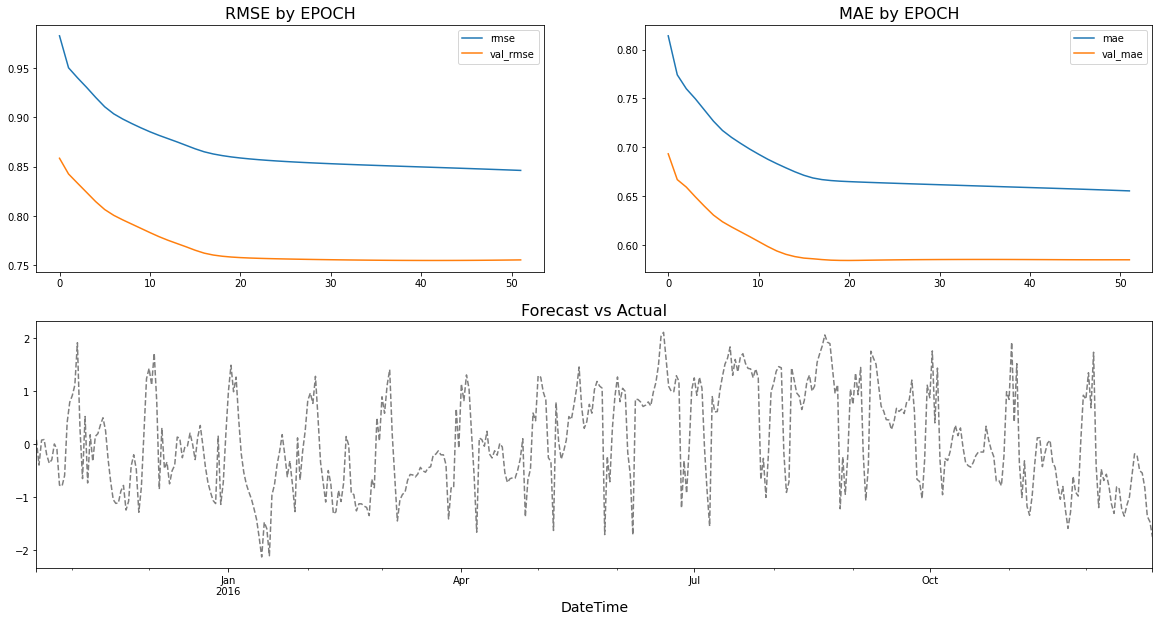

In [141]:
model_dw_td = create_model(x_train_dw, units=32)
history_dw_td = train_model(model_dw_td, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)
plot_forecast(model_dw_td, x_test_dw, y_test_dw, test_dw.index, history_dw_td)

### Energy Consumption

In [ ]:
model_en_td = create_model(x_train_en, units=32)
history_en_td = train_model(model_en_td, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)
plot_forecast(model_en_td, x_test_en, y_test_en, test_en.index, history_en_td)

## Compare

In [ ]:
scores = pd.DataFrame(np.array(
    [model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_a_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_a_gru.evaluate(x=x_test_air, y=y_test_air),
    model_a_deep.evaluate(x=x_test_air, y=y_test_air),
    model_a_bd.evaluate(x=x_test_air, y=y_test_air),
    model_a_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM', 'Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

In [ ]:
scores = pd.DataFrame(np.array(
    [model_dw_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_dw_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_dw_gru.evaluate(x=x_test_air, y=y_test_air),
    model_dw_deep.evaluate(x=x_test_air, y=y_test_air),
    model_dw_bd.evaluate(x=x_test_air, y=y_test_air),
    model_dw_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

In [ ]:
scores = pd.DataFrame(np.array(
    [model_en_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_en_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_en_gru.evaluate(x=x_test_air, y=y_test_air),
    model_en_deep.evaluate(x=x_test_air, y=y_test_air),
    model_en_bd.evaluate(x=x_test_air, y=y_test_air),
    model_en_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM','Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

## There is more

Using Keras Model API 

In [ ]:
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout, Input,
                Activation)

In [ ]:
def create_model(train, units, dropout=0.2):
    input_data = Input(shape=(None, None, train.shape[1]))
    lstm1 = LSTM(units)(input_data)
    dropout_1 = BatchNormalization()(lstm1)
    lstm2 = LSTM(units)(dropout_1)
    # dropout_2 = Dropout(dropout)(lstm_2)
    output = Dense(1, )(lstm2)
    model = Model(inputs=input_data, outputs=output)
    
    return model

In [ ]:
x_train_air.shape

In [ ]:
model_a_m = create_model(train=x_train_air, units=32)
model_a_m.summary()

### Air Passenger

In [ ]:
history_a_m = train_model(model_a_m, x_train_air, y_train_air, x_val_air, y_val_air)

In [ ]:
model_a_m.evaluate(x=x_test_air, y=y_test_air)

In [ ]:
plot_forecast(model_a_m, x_test_air, y_test_air, test_air.index, history_a_m)